In [97]:
import numpy as np
import matplotlib.pyplot as plt
import string
import codecs
import re
import os.path
from spellchecker import SpellChecker
import snowballstemmer
import unicodedata
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.svm import LinearSVC
from sklearn import svm 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, auc
from sklearn.neural_network import MLPClassifier
from tqdm import tqdm
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import json
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

# Données classification de sentiments (films)

In [84]:
def load_movies_small(path2data): # 1 classe par répertoire
    alltxts = [] # init vide
    labs = []
    cpt = 0
    for cl in os.listdir(path2data): # parcours des fichiers d'un répertoire
        for f in os.listdir(path2data+cl):
            txt = open(path2data+cl+'/'+f).read()
            alltxts.append(txt)
            labs.append(cpt)
        cpt+=1 # chg répertoire = cht classe
        
    return np.array(alltxts),np.array(labs)


def create_output_file(y_pred,name):
    with open("test_eval_movies_with_large_dataset"+name+".txt",'w') as f:
        for y in y_pred:
            if y == 0:
                f.write("N")
                f.write("\n")
            else:
                f.write("P")
                f.write("\n")

def load_movies_large():

    # Loading json
    with open("./datasets/movies/movieslarge/json_pol",encoding="utf-8") as f:
        data = f.readlines()
        json_data = json.loads(data[0])
        train = json_data["train"]
        test = json_data["test"]
        
    data_train = []
    data_test = []
    
    label_test = []
    label_train = []
    for i,data in enumerate(train):
        data_train.append(data[0])
        label_train.append(data[1])
        
        data_test.append(test[i][0])
        label_test.append(test[i][1])
            

    return data_train,label_train,data_test,label_test

def get_stats(label):
    
    [clpos,claneg],[nbpos,nbneg] = np.unique(label_large_train,return_counts=True)
    print("Nombre de documents classés positifs ",nbpos)
    print("Nombre de documents classés négatifs ",nbneg)
    
    plt.title("Distribution des classes sur les documents")
    plt.hist(label)
    
# les poids relatifs au metriques de base
w_accuracy = 0.5
w_f1score = 0.25
w_auc = 0.25

def metrique_globale(ytest,ypred):
    accuracy = accuracy_score(ytest,ypred)
    fpr, tpr, thresholds = roc_curve(y_test,y_scores)
    roc_auc = auc(fpr, tpr)
    f1_score = precision_recall_fscore_support(y_true, y_pred)[2]
    return w_accuracyaccuracy + w_f1scoref1score + w_auc*roc_auc

# Affichage du nuage de points de notre base
def get_nuage_points(vectors,alllabs):
    svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
    U = svd.fit_transform(vectors)
    V = svd.components_

    tsne = TSNE(n_components=2, init='pca',n_iter=5000, verbose=0)
    tsne_mat = tsne.fit_transform(U)
    NN2cluster = np.argmax(np.abs(U), axis=0)

    plt.figure(figsize=(15,10))
    plt.scatter(tsne_mat[:,0],tsne_mat[:,1],c=alllabs, s=10)
    
def supp_punc(chaine) : 
    punc = string.punctuation  
    punc += '\n\r\t'
    chaine = chaine.translate(str.maketrans(punc, ' ' * len(punc))) 
    return chaine
def supp_punc_chiffre(chaine) : 
    chaine = supp_punc(chaine)
    chaine = re.sub('[0-9]',"", chaine)
    return chaine
def filtred_stop_word(liste) : 
    stopWord = stopwords.words('french') + stopwords.words('english')
    res = []
    for word,cpt in liste:
        if word not in stopWord :
            res.append(word + " ")
    return res

def get_number_sentences(texte):
    splited_text = texte.split('.')
    count = len(splited_text)
    number_sentences = int(count * 0.3)
    text1 = splited_text[:number_sentences]
    text2 = splited_text[-number_sentences:]
    return ''.join(map(str,text1)) + ''.join(map(str,text2))


def preprocess_strat1(text):
    # un mot syntaxiquement correcte 
    text = supp_punc_chiffre(text)
    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("utf-8")
    text = text.lower()
    return text.replace("."," ") 
def preprocess_strat2(text) :
    default_word = '<MOT_EN_MAJUSCULES>'
    text = supp_punc_chiffre(text)
    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("utf-8")
    text = re.sub(r'\b[A-Z]+\b',default_word, text)
    return text
def preprocess_strat3(text):
    default_word = '<MOT_EN_MAJUSCULES>'
    text = supp_punc(text)
    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("utf-8")
    text = re.sub(r'\b[A-Z]+\b',default_word, text)
    return text
 
def preprocess_strat4(text) : 
    text = supp_punc_chiffre(text)
    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("utf-8")
    return text

def preprocess_strat5(text):
    text = supp_punc_chiffre(text)
    text = get_number_sentences(text)
    return text

def preprocess_strat6(text) : 
    default_word = '<MOT_EN_MAJUSCULES>'
    text = supp_punc_chiffre(text)
    text = get_number_sentences(text)
    text = re.sub(r'\b[A-Z]+\b',default_word, text)
    return text

def database_stemming(data):
    data_stemmer = []
    stemmer = snowballstemmer.stemmer("english")
    for doc in tqdm(data):
        chaine = ""
        for word in doc.split(" "):
            chaine += stemmer.stemWord(word)+" "
        data_stemmer.append(chaine)
    return data_stemmer

In [80]:
path = "./datasets/movies/movies1000/"
data_small,label_small = load_movies_small(path)

data_large_train,label_large_train,data_large_test,label_large_test = load_movies_large()
#data_large_train_stemmed = database_stemming(data_large_train)

Nombre de documents classés positifs  12500
Nombre de documents classés négatifs  12500


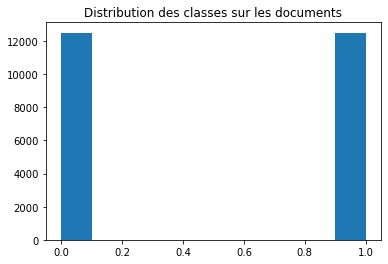

In [25]:
get_stats(label_large_train)

In [5]:
len(data_large_test)

25000

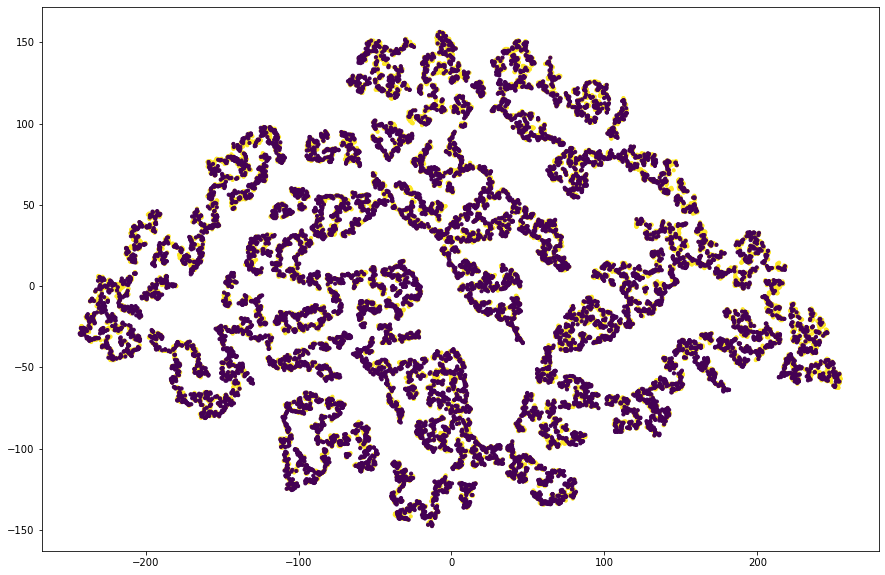

In [29]:
vectorizer = CountVectorizer()
vectors = vectorizer.fit_transform(data_large_train)
get_nuage_points(vectors,label_large_train)

# A) Transformation paramétrique du texte (pre-traitements)

Vous devez tester, par exemple, les cas suivants:
- transformation en minuscule ou pas
- suppression de la ponctuation
- transformation des mots entièrement en majuscule en marqueurs spécifiques
- suppression des chiffres ou pas
- conservation d'une partie du texte seulement (seulement la première ligne = titre, seulement la dernière ligne = résumé, ...)
- stemming
- ...


Vérifier systématiquement sur un exemple ou deux le bon fonctionnement des méthodes sur deux documents (au moins un de chaque classe).

## Fonctions Utiles

- Dans cette stratégie , On verifie d'abord que le mot existe dans le vocabulaire (anglais ou francais), puis nous gardons dans chaque document uniquement les 3 premieres phrases et les 3 dernieres.
- Nous mettons l'hypothese que les trois premieres phrases et les trois dernieres vont reveler les sentiments du lecteur sur le film "en grande partie
- On supprime ls majuscules et les chiffres et la ponctuation

In [92]:
liste_preprocess = [preprocess_strat1,preprocess_strat2,preprocess_strat3,preprocess_strat4,preprocess_strat5]
doc_classe_1 = data_small[label_small==0][0]
doc_classe_2 = data_small[label_small==1][0]
print("le document 1 avant toute modification :\n\n",doc_classe_1)
for i in range(len(liste_preprocess)) : 
    print("------------------- PREPROCESS STRAT" + str(i+1) + "-----------------------")
    print(liste_preprocess[i](doc_classe_1))
    print("----------------------------------------------------------------------------")

le document 1 avant toute modification :

 plot : two teen couples go to a church party , drink and then drive . 
they get into an accident . 
one of the guys dies , but his girlfriend continues to see him in her life , and has nightmares . 
what's the deal ? 
watch the movie and " sorta " find out . . . 
critique : a mind-fuck movie for the teen generation that touches on a very cool idea , but presents it in a very bad package . 
which is what makes this review an even harder one to write , since i generally applaud films which attempt to break the mold , mess with your head and such ( lost highway & memento ) , but there are good and bad ways of making all types of films , and these folks just didn't snag this one correctly . 
they seem to have taken this pretty neat concept , but executed it terribly . 
so what are the problems with the movie ? 
well , its main problem is that it's simply too jumbled . 
it starts off " normal " but then downshifts into this " fantasy " world in whi

In [93]:
print("le document 2 avant toute modification :\n\n",doc_classe_2)
for i in range(len(liste_preprocess)) : 
    print("------------------- PREPROCESS STRAT" + str(i+1) + "-----------------------")
    print(liste_preprocess[i](doc_classe_2))
    print("----------------------------------------------------------------------------")

le document 2 avant toute modification :

 films adapted from comic books have had plenty of success , whether they're about superheroes ( batman , superman , spawn ) , or geared toward kids ( casper ) or the arthouse crowd ( ghost world ) , but there's never really been a comic book like from hell before . 
for starters , it was created by alan moore ( and eddie campbell ) , who brought the medium to a whole new level in the mid '80s with a 12-part series called the watchmen . 
to say moore and campbell thoroughly researched the subject of jack the ripper would be like saying michael jackson is starting to look a little odd . 
the book ( or " graphic novel , " if you will ) is over 500 pages long and includes nearly 30 more that consist of nothing but footnotes . 
in other words , don't dismiss this film because of its source . 
if you can get past the whole comic book thing , you might find another stumbling block in from hell's directors , albert and allen hughes . 
getting the hugh

# B) Extraction du vocabulaire (BoW)

- **Exploration préliminaire des jeux de données**
    - Quelle est la taille d'origine du vocabulaire?
    - Que reste-t-il si on ne garde que les 100 mots les plus fréquents? [word cloud]
    - Quels sont les 100 mots dont la fréquence documentaire est la plus grande? [word cloud]
    - Quels sont les 100 mots les plus discriminants au sens de odds ratio? [word cloud]
    - Quelle est la distribution d'apparition des mots (Zipf)
    - Quels sont les 100 bigrammes/trigrammes les plus fréquents?

- **Variantes de BoW**
    - TF-IDF
    - Réduire la taille du vocabulaire (min_df, max_df, max_features)
    - BoW binaire
    - Bi-grams, tri-grams
    - **Quelles performances attendrent? Quels sont les avantages et les inconvénients des ces variantes?**

In [32]:
final_stopwords_list = stopwords.words('english') + stopwords.words('french')

## 100 Mots

###  les plus frequent dans chaque document

In [33]:
#Garder les 100 mots les plus frequent dans chaque document ( en enlevant la ponctuation et les stops words)
def get_mots_frequent_par_doc(alltxts):
    corpus = []
    punc = string.punctuation
    for doc in alltxts :
        vocab = dict()
        doc = doc.translate(str.maketrans(punc, " "* len(punc)))
        for word in doc.split() : 
            if word in vocab.keys(): 
                vocab[word] += 1
            else : 
                vocab[word]=1
        #100 mots les plus frequent 
        l = sorted(vocab.items(),key = lambda x : x[1],reverse=True)
        l = filtred_stop_word(l)[: 100]
        chaine = ""
        for word in l :
            chaine += word+ " "  
        corpus.append(chaine)
    return corpus

la taille du vocabulaire si on ne garde que les 100 mots les plus fréquents est :  62851


(-0.5, 399.5, 199.5, -0.5)

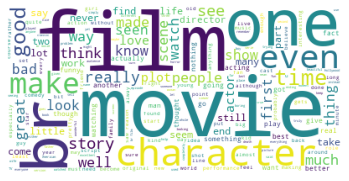

In [34]:
corpus = get_mots_frequent_par_doc(data_large_train)
corpus_word = "".join(corpus)
vectorize = CountVectorizer()
X_freq = vectorize.fit_transform(corpus).toarray()
print("la taille du vocabulaire si on ne garde que les 100 mots les plus fréquents est : " ,len(vectorize.get_feature_names_out()))
#print(corpus)
wordcoud = WordCloud(background_color = "white").generate(corpus_word)

plt.figure()
plt.imshow(wordcoud)
plt.axis("off")

### frequences documentaire

les 100 mots les plus frequents dans le documents sont :
 ['the' 'and' 'br' 'of' 'to' 'is' 'it' 'in' 'this' 'that' 'movie' 'was'
 'film' 'as' 'you' 'for' 'but' 'with' 'on' 'not' 'he' 'are' 'have' 'his'
 'one' 'be' 'they' 'all' 'at' 'so' 'like' 'her' 'by' 'who' 'an' 'just'
 'there' 'from' 'if' 'good' 'or' 'about' 'out' 'what' 'very' 'some' 'she'
 'has' 'my' 'can' 'more' 'really' 'story' 'time' 'when' 'no' 'would' 'see'
 'even' 'bad' 'me' 'up' 'were' 'had' 'only' 'we' 'great' 'which' 'well'
 'their' 'don' 'people' 'movies' 'will' 'much' 'than' 'get' 'do' 'how'
 'because' 'been' 'made' 'first' 'watch' 'its' 'other' 'think' 'also'
 'could' 'most' 'acting' 'make' 'seen' 'too' 'show' 'into' 'then' 'way'
 'plot' 'characters']


(-0.5, 399.5, 199.5, -0.5)

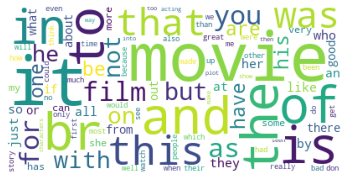

In [35]:
vectorizer = TfidfVectorizer()
X_freq_doc = vectorizer.fit_transform(data_large_train)
freq = X_freq_doc.sum(axis=0).A1
indice_100 = np.argsort(-freq)[:100]
mots_freq = np.array(vectorizer.get_feature_names_out())[indice_100]
print("les 100 mots les plus frequents dans le documents sont :\n", mots_freq)

corpus_100_freq =""
for mots in mots_freq : 
    corpus_100_freq += mots+" "
wordcoud_freq = WordCloud(background_color = "white",stopwords="").generate(corpus_100_freq)
plt.figure()
plt.imshow(wordcoud_freq)
plt.axis("off")

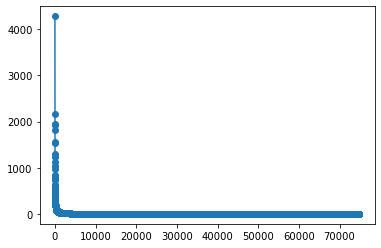

In [36]:
indice = np.argsort(-freq)
freq = freq[indice]
plt.plot(range(len(freq)),freq,marker ='o')

### Odds Ratio

['flags', 'flagrantly', 'flagrante', 'flagrant', 'flagpole', 'flagstaff', 'flakes', 'flakey', 'flakiest', 'flamin', 'flamethrowers', 'flamethrower', 'flames', 'flamengo', 'flamenco', 'flamed', 'flame', 'flambé', 'flamboyantly', 'flamboyant', 'flamboyance', 'flambards', 'flam', 'flaky', 'flashlight', 'flashlights', 'flashman', 'flashpoint', 'flavourless', 'flavouring', 'flavoured', 'flavour', 'flavorsome', 'flavors', 'flaw', 'flavorless', 'flavoring', 'flavorful', 'flavored', 'flavor', 'flavius', 'flavin', 'flavorings', 'flawed', 'flawing', 'flawless', 'flecked', 'fleck', 'fleashens', 'fleas', 'fleapit', 'fleadh', 'fleabag', 'flea', 'flds', 'flaying', 'flayed', 'flay', 'flaws', 'flawlessness', 'flawlessly', 'flavia', 'floozies', 'flava', 'flaunts', 'flatmates', 'flatmate', 'flatman', 'flatly', 'flatlines', 'flatlined', 'flatness', 'flatley', 'flatiron', 'flatfeet', 'flat', 'flask', 'flashy', 'flashpots', 'flatlands', 'flatop', 'flats', 'flatson', 'flaunting', 'flaunted', 'flaunt', 'flau

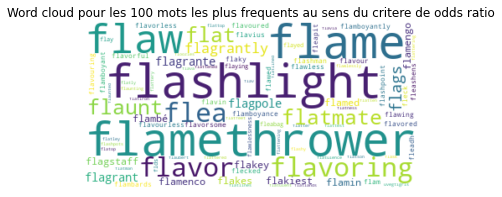

In [38]:
def get_Wordcloud_odds_ratio(X,labels_films):
    X_0 = X[np.where(labels_films == 0)[0]]
    X_1 = X[np.where(labels_films == 1)[0]]

    frequencies_0 = [np.sum(X_0[:,i]) for i in range(X_0.shape[1])]
    frequencies_1 = [np.sum(X_0[:,i]) for i in range(X_0.shape[1])]

    odds_ratio = [np.log((frequencies_0[i]*(1 - frequencies_1[i])) / (frequencies_1[i]*(1 - frequencies_0[i]))) for i in range(len(frequencies_0))]
    ind_freq = np.argsort(odds_ratio)[-100:]
    mots_freq3 = [vectorizer.get_feature_names_out()[i] for i in ind_freq]
    print(mots_freq3)

    w_cloud = ""
    for elem in mots_freq3:
        w_cloud += str(elem)+" " 

    wordcloud = WordCloud(background_color='White').generate(w_cloud)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title("Word cloud pour les 100 mots les plus frequents au sens du critere de odds ratio")
    plt.axis("off")
    plt.show()
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data_large_train)
get_Wordcloud_odds_ratio(X,label_large_train)

# Binary BOW

les 100 mots les plus frequents dans le documents sont :
 ['movie' 'br' 'one' 'film' 'like' 'good' 'time' 'even' 'would' 'see'
 'really' 'story' 'well' 'much' 'get' 'also' 'first' 'made' 'great'
 'people' 'make' 'way' 'could' 'bad' 'watch' 'think' 'acting' 'movies'
 'seen' 'characters' 'many' 'plot' 'never' 'two' 'best' 'little'
 'character' 'ever' 'know' 'better' 'life' 'films' 'end' 'love' 'still'
 'say' 'go' 'something' 'man' 'back' 'scenes' 'watching' 'scene' 'thing'
 'real' 'years' 'actors' 'another' 'though' 'director' 'makes' 'work'
 'old' 'look' 'actually' 'nothing' 'find' '10' 'going' 'show' 'every'
 'lot' 'cast' 'new' 'part' 'funny' 'want' 'quite' 'got' 'things' 'take'
 'around' 'fact' 'give' 'however' 'long' 'thought' 'pretty' 'seems'
 'world' 'enough' 'big' 'without' 'come' 'times' 'must' 'right' 'us' 'saw'
 'least']


(-0.5, 399.5, 199.5, -0.5)

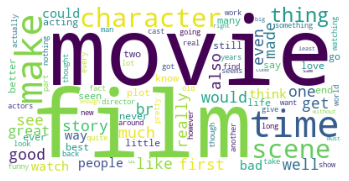

In [39]:
vectorizer = CountVectorizer(stop_words = final_stopwords_list,binary=True)
bow_binary = vectorizer.fit_transform(data_large_train) 
freq = bow_binary.sum(axis=0).A1
indice_100 = np.argsort(-freq)[:100]
mots_freq = np.array(vectorizer.get_feature_names_out())[indice_100]
print("les 100 mots les plus frequents dans le documents sont :\n", mots_freq)

corpus_100_freq =""
for mots in mots_freq : 
    corpus_100_freq += mots+" "
wordcoud_freq = WordCloud(background_color = "white",stopwords="").generate(corpus_100_freq)
plt.figure()
plt.imshow(wordcoud_freq)
plt.axis("off")

## Bigramme

In [40]:
vectorize  = TfidfVectorizer(ngram_range=(2,2))
X = vectorize.fit_transform(data_large_train)
freq = X.sum(axis=0).A1
indice = np.argsort(-freq)[:100]
print("les bigramme les plus frequent sont : \n", np.array(vectorize.get_feature_names_out())[indice])

les bigramme les plus frequent sont : 
 ['br br' 'of the' 'in the' 'this movie' 'the movie' 'the film' 'this film'
 'and the' 'to be' 'it is' 'to the' 'this is' 'it was' 'one of' 'if you'
 'on the' 'for the' 'br the' 'with the' 'is the' 'at the' 'in this'
 'movie is' 'to see' 'the story' 'from the' 'as the' 'that the' 'out of'
 'the first' 'all the' 'there is' 'by the' 'have been' 'film is' 'of this'
 'but it' 'is not' 'the best' 'this one' 'that it' 'the end' 'and it'
 'there are' 'to watch' 'the same' 'but the' 'the only' 'the plot'
 'the most' 'to make' 'about the' 'that is' 'the acting' 'the characters'
 'have to' 'movie was' 'was the' 'he is' 'want to' 'you can' 'of his'
 'some of' 'the worst' 'this was' 'is one' 'would have' 'lot of' 'to get'
 'is that' 'at least' 'they are' 'the way' 'would be' 'the other' 'to do'
 'the whole' 'is very' 'kind of' 'br this' 'the original' 'that this'
 'as well' 'into the' 'like the' 'at all' 'trying to' 'but this' 'you re'
 'to have' 'most of' 'c

## Trigramme

In [41]:
vectorize  = TfidfVectorizer(ngram_range=(3,3))
X = vectorize.fit_transform(data_large_train)
freq = X.sum(axis=0).A1
indice = np.argsort(-freq)[:100]
print("les trigramme les plus frequent sont : \n", np.array(vectorize.get_feature_names_out())[indice])

les trigramme les plus frequent sont : 
 ['br br the' 'one of the' 'this movie is' 'of the film' 'br br this'
 'of the movie' 'this film is' 'is one of' 'some of the' 'the film is'
 'in this movie' 'br br it' 'the movie is' 'this movie was' 'in the movie'
 'in this film' 'the fact that' 'in the film' 'this is the' 'the rest of'
 'at the end' 'most of the' 'it br br' 'the story is' 'the acting is'
 'of the best' 'movie br br' 'of the most' 'rest of the' 'br br if'
 'of this movie' 'if you re' 'the end of' 'could have been' 'this is one'
 'as well as' 'br br there' 'out of 10' 'out of the' 'of this film'
 'the movie was' 'if you are' 'have ever seen' 'supposed to be'
 'film br br' 'br br in' 'would have been' 'you want to' 'the plot is'
 'there is no' 'part of the' 'if you want' 'end of the' 'one of those'
 'br br but' 'in the end' 'this film was' 'of the worst' 'br br and'
 'br this is' 'to see this' 'to see it' 'br if you' 'but it is'
 've ever seen' 'this movie and' 'one of my' 'this 

##   Performances : avantages et les inconvénients des ces variantes

- Pour le model binaire : bonne performance lorsque la presence d'un mot ou non est plus descriminante que la fréquence de ce mot, son principale inconvenient est qu'elle ne prend pas en copte la frequence du mot, par exemple un document qui contient un mot 50 fois va etre représenter de la meme maniere qu'un document qui en a q'un seul, alors qu'ils sont trés differents 
- Bi-gramme, tri-gramme : capture la relation sémantique entre les mots, mais l'incovénient est que si on avait beaucoup de dimension au début, cette derniere accroitera d'une maniere trés grande ce qui rends le model complex

- Réduire la taille du vocabulaire : l'avantage principale est qu'il permet de réduire la dimension du vocabulaire ce qui rends le model moins complex, cepandant, on peut éléminer des mots descriminant pour un document, donc une perte d'information trés importante
- TF-IDF : le plus grand avantage c'est qu'il detecte les mots les plus descriminant dans chaque document par rapport au corpus, cepandant, il peut attribuer des poids importants pour des mots rares qui n'ont pas de signification précise pour un genre de document

# C) Modèles de Machine Learning

## 1) Métriques d'évaluation 

Il faudra utiliser des métriques d'évaluation pertinentes suivant la tâche et l'équilibrage des données : 
- Accuracy
- Courbe ROC, AUC, F1-score

#### Création des vectorizer

In [42]:
liste_starts = [preprocess_strat1,preprocess_strat2,preprocess_strat3,preprocess_strat4,preprocess_strat5,preprocess_strat6]
liste_Cvectorizer = [CountVectorizer(stop_words=final_stopwords_list)]
                                    
for strat in liste_starts:
    liste_Cvectorizer.append(CountVectorizer(stop_words=final_stopwords_list, preprocessor = strat,max_df = 0.95, min_df = 4))

liste_Cvectorizer.append(CountVectorizer(stop_words=final_stopwords_list, preprocessor = preprocess_strat3, ngram_range = (2,2),max_features=10000))
liste_Cvectorizer.append(CountVectorizer(stop_words=final_stopwords_list, preprocessor = preprocess_strat1, ngram_range = (3,3),max_features= 10000))
# start3 for stemmed data
liste_Cvectorizer.append(CountVectorizer(stop_words=final_stopwords_list, preprocessor = preprocess_strat3,max_df = 0.95, min_df = 4))

#### TF-IDF

In [43]:
liste_TFvectorizer = [TfidfVectorizer(stop_words=final_stopwords_list)]
                                    
for strat in liste_starts:
    liste_TFvectorizer.append(TfidfVectorizer(stop_words=final_stopwords_list, preprocessor = strat,max_df = 0.95, min_df = 4))
# start3 for stemmed data
liste_TFvectorizer.append(TfidfVectorizer(stop_words=final_stopwords_list, preprocessor = preprocess_strat3,max_df = 0.95, min_df = 4))

In [44]:
# Split sur le data small
X_train, X_test, y_train, y_test = train_test_split(data_small, label_small, test_size=0.2)
# Le data large etant deja splité

#### Fit Vectorizer

In [45]:
liste_X_train_C = []
liste_X_train_TF = []

for i,vect in tqdm(enumerate(liste_Cvectorizer[:3])):
    liste_X_train_C.append(vect.fit_transform(data_large_train))
    liste_X_train_TF.append(liste_TFvectorizer[i].fit_transform(data_large_train))  

3it [01:20, 26.93s/it]


In [46]:
for vect in tqdm(liste_Cvectorizer[3:]):
    liste_X_train_C.append(vect.fit_transform(data_large_train_stemmed))
for vect in tqdm(liste_TFvectorizer[3:]):
    liste_X_train_TF.append(vect.fit_transform(data_large_train_stemmed))    

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:20<00:00, 16.14s/it]


#### Transformation données de test selon les vectorizers entrainée 

In [47]:
liste_X_test_C = []
liste_X_test_TF = []

for vect in tqdm(liste_Cvectorizer):
    liste_X_test_C.append(vect.transform(data_large_test))
    
for vect in tqdm(liste_TFvectorizer):    
    liste_X_test_TF.append(vect.transform(data_large_test))

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:46<00:00, 13.32s/it]


# Optimisation et Apprentissage

## Linaire SVM

### CountVectorizer

In [88]:
liste_score_C_linsvm = []
parameters = {'C':[0.001,0.01, 0.1]}
for i, X_train in tqdm(enumerate(liste_X_train_C)): 
    X_test = liste_X_test_C[i]
    svc = LinearSVC()
    gridSCV = GridSearchCV(svc, parameters, cv=3, scoring=metrique_globale)
    gridSCV.fit(X_train,label_large_train)
    best_svc = gridSCV.best_estimator_
    y_pred = best_svc.predict(X_test)
    liste_score_C_linsvm.append((best_svc,accuracy_score(label_large_test,y_pred)))

10it [02:43, 16.33s/it]


In [89]:
print(liste_score_C_linsvm)

[(LinearSVC(C=0.001), 0.87956), (LinearSVC(C=0.001), 0.87916), (LinearSVC(C=0.001), 0.87884), (LinearSVC(C=0.001), 0.84844), (LinearSVC(C=0.001), 0.85076), (LinearSVC(C=0.001), 0.85044), (LinearSVC(C=0.001), 0.84832), (LinearSVC(C=0.001), 0.74048), (LinearSVC(C=0.001), 0.60504), (LinearSVC(C=0.001), 0.84844)]


### TF-IDF

In [75]:
liste_score_TF_linsvm = []
parameters = {'C':[0.01, 0.1, 1.5,2]}
for i,X_train in tqdm(enumerate(liste_X_train_TF)) : 
    X_test = liste_X_test_TF[i]
    svc = LinearSVC()
    clf = GridSearchCV(svc, parameters, cv=3, scoring=metrique_globale)
    clf.fit(X_train,label_large_train)
    best_svc = clf.best_estimator_
    y_pred = best_svc.predict(X_test)
    liste_score_TF_linsvm.append((best_svc,accuracy_score(label_large_test,y_pred)))

8it [00:44,  5.54s/it]


In [76]:
print(liste_score_TF_linsvm)

[(LinearSVC(C=0.01), 0.85844), (LinearSVC(C=0.01), 0.85948), (LinearSVC(C=0.01), 0.85272), (LinearSVC(C=0.01), 0.8212), (LinearSVC(C=0.01), 0.8262), (LinearSVC(C=0.01), 0.8262), (LinearSVC(C=0.01), 0.82128), (LinearSVC(C=0.01), 0.8212)]


## SVM

In [ ]:
liste_score_C_svm = []
parameters = {'C':[0.01, 0.1, 1.2]}
for i, X_train in tqdm(enumerate(liste_X_train_C)): 
    X_test = liste_X_test_C[i]
    svc = svm.SVC()
    gridSCV = GridSearchCV(svc, parameters, cv=3, scoring=metrique_globale)
    gridSCV.fit(X_train,label_large_train)
    best_svc = gridSCV.best_estimator_
    y_pred = best_svc.predict(X_test)
    liste_score_C_svm.append((best_svc,accuracy_score(label_large_test,y_pred)))

In [ ]:
print(liste_score_C_svm)

In [ ]:
liste_score_TF_svm = []
parameters = {'C':[0.01, 0.1, 1.5,2]}
for i,X_train in tqdm(enumerate(liste_X_train_TF)) : 
    X_test = liste_X_test_TF[i]
    svc = svm.SVC()
    clf = GridSearchCV(svc, parameters, cv=3, scoring=metrique_globale)
    clf.fit(X_train,label_large_train)
    best_svc = clf.best_estimator_
    y_pred = best_svc.predict(X_test)
    liste_score_TF_svm.append((best_svc,accuracy_score(label_large_test,y_pred)))

In [ ]:
print(liste_score_TF_svm)

## REGRESSION LOGISTIQUE

### CountVectorizer

In [48]:
liste_score_C_lr = []
hyperparameters = {'C': [0.001, 0.01, 0.1], 'penalty': ['l2']}

for i, X_train in tqdm(enumerate(liste_X_train_C)): 
    X_test = liste_X_test_C[i]
    lr = LogisticRegression(max_iter= 1000)
    
    gridSCV = GridSearchCV(lr, hyperparameters, cv=3,scoring=metrique_globale)
    gridSCV.fit(X_train,label_large_train)
    best_params = gridSCV.best_params_
    
    best_lr = LogisticRegression(**best_params, max_iter= 1000)
    best_lr.fit(X_train, label_large_train)
    y_pred = best_lr.predict(X_test)
    liste_score_C_lr.append((best_lr,accuracy_score(label_large_test,y_pred)))

10it [08:22, 50.23s/it]


In [49]:
print(liste_score_C_lr)

[(LogisticRegression(C=0.001, max_iter=1000), 0.8518), (LogisticRegression(C=0.001, max_iter=1000), 0.85212), (LogisticRegression(C=0.001, max_iter=1000), 0.85004), (LogisticRegression(C=0.001, max_iter=1000), 0.81256), (LogisticRegression(C=0.001, max_iter=1000), 0.81612), (LogisticRegression(C=0.001, max_iter=1000), 0.81608), (LogisticRegression(C=0.001, max_iter=1000), 0.81232), (LogisticRegression(C=0.001, max_iter=1000), 0.68048), (LogisticRegression(C=0.001, max_iter=1000), 0.58236), (LogisticRegression(C=0.001, max_iter=1000), 0.81256)]


### TF - IDF

In [50]:
liste_score_TF_lr = []
hyperparameters = {'C': [0.001, 0.01, 0.1], 'penalty': ['l2']}

for i, X_train in tqdm(enumerate(liste_X_train_TF)): 
    X_test = liste_X_test_TF[i]
    lr = LogisticRegression(max_iter= 1000)
    
    gridSCV = GridSearchCV(lr, hyperparameters, cv=3,scoring=metrique_globale)
    gridSCV.fit(X_train,label_large_train)
    best_params = gridSCV.best_params_
    
    best_lr = LogisticRegression(**best_params, max_iter= 1000)
    best_lr.fit(X_train, label_large_train)
    y_pred = best_lr.predict(X_test)
    liste_score_TF_lr.append((best_lr,accuracy_score(label_large_test,y_pred)))

8it [01:10,  8.84s/it]


In [51]:
print(liste_score_TF_lr)

[(LogisticRegression(C=0.001, max_iter=1000), 0.78748), (LogisticRegression(C=0.001, max_iter=1000), 0.7868), (LogisticRegression(C=0.001, max_iter=1000), 0.74844), (LogisticRegression(C=0.001, max_iter=1000), 0.71164), (LogisticRegression(C=0.001, max_iter=1000), 0.74216), (LogisticRegression(C=0.001, max_iter=1000), 0.7422), (LogisticRegression(C=0.001, max_iter=1000), 0.7108), (LogisticRegression(C=0.001, max_iter=1000), 0.71164)]


## Arbre de decision

## Vectorizer

In [52]:
liste_score_C_tree = []
param_grid = {
    'max_depth': [5, 10, 13, None],
    'min_samples_split': [2, 5, 10]
}
for i, X_train in tqdm(enumerate(liste_X_train_C)):
    X_test = liste_X_test_C[i]
    rfc = RandomForestClassifier()
    grid_search = GridSearchCV(rfc, param_grid, cv=2, scoring=metrique_globale)
    grid_search.fit(X_train, label_large_train)
    best_rfc = grid_search.best_estimator_
    y_pred = best_rfc.predict(X_test)
    liste_score_C_tree.append((best_rfc,accuracy_score(label_large_test, y_pred)))

10it [1:34:59, 569.91s/it]


In [53]:
print(liste_score_C_tree)

[(RandomForestClassifier(max_depth=5), 0.81252), (RandomForestClassifier(max_depth=5), 0.81632), (RandomForestClassifier(max_depth=5), 0.81804), (RandomForestClassifier(max_depth=5), 0.77764), (RandomForestClassifier(max_depth=5), 0.78212), (RandomForestClassifier(max_depth=5), 0.79124), (RandomForestClassifier(max_depth=5), 0.78976), (RandomForestClassifier(max_depth=5), 0.6584), (RandomForestClassifier(max_depth=5), 0.56868), (RandomForestClassifier(max_depth=5), 0.78536)]


## IF-IDF

In [54]:
liste_score_TF_tree = []
param_grid = {
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10]
}

for i, X_train in tqdm(enumerate(liste_X_train_TF)):
    X_test = liste_X_test_TF[i]
    rfc = RandomForestClassifier()
    grid_search = GridSearchCV(rfc, param_grid, cv=2, scoring=metrique_globale)
    grid_search.fit(X_train, label_large_train)
    best_rfc = grid_search.best_estimator_
    y_pred = best_rfc.predict(X_test)
    liste_score_TF_tree.append((best_rfc,accuracy_score(label_large_test, y_pred)))

8it [43:45, 328.16s/it]


In [55]:
print(liste_score_TF_tree)

[(RandomForestClassifier(max_depth=5), 0.81236), (RandomForestClassifier(max_depth=5), 0.82056), (RandomForestClassifier(max_depth=5), 0.8054), (RandomForestClassifier(max_depth=5), 0.77096), (RandomForestClassifier(max_depth=5), 0.77768), (RandomForestClassifier(max_depth=5), 0.78044), (RandomForestClassifier(max_depth=5), 0.76632), (RandomForestClassifier(max_depth=5), 0.75864)]


## Naive Bayes

### Vectorizer

In [56]:
liste_score_C_nb = []
param_grid = {
    'alpha': [0.1, 0.5, 1, 2],
    'fit_prior': [True, False]
}

for i, X_train in tqdm(enumerate(liste_X_train_C)):
    X_test = liste_X_test_C[i]
    nb = MultinomialNB()
    grid_search = GridSearchCV(nb, param_grid, cv=2, scoring=metrique_globale)
    grid_search.fit(X_train, label_large_train)
    best_nb = grid_search.best_estimator_
    best_nb.fit(X_train, label_large_train)
    y_pred = best_nb.predict(X_test)
    liste_score_C_nb.append((best_nb, accuracy_score(label_large_test, y_pred)))


10it [00:15,  1.51s/it]


In [57]:
print(liste_score_C_nb)

[(MultinomialNB(alpha=0.1), 0.80988), (MultinomialNB(alpha=0.1), 0.82164), (MultinomialNB(alpha=0.1), 0.816), (MultinomialNB(alpha=0.1), 0.80196), (MultinomialNB(alpha=0.1), 0.80492), (MultinomialNB(alpha=0.1), 0.80492), (MultinomialNB(alpha=0.1), 0.8022), (MultinomialNB(alpha=0.1), 0.77216), (MultinomialNB(alpha=0.1), 0.62692), (MultinomialNB(alpha=0.1), 0.80196)]


## TF-IDF

In [58]:
liste_score_TF_nb = []
param_grid = {
    'alpha': [0.1, 0.5, 1, 2],
    'fit_prior': [True, False]
}

for i,X_train in tqdm(enumerate(liste_X_train_TF)):
    X_test = liste_X_test_TF[i]
    nb = MultinomialNB()
    grid_search = GridSearchCV(nb, param_grid, cv=2, scoring=metrique_globale)
    grid_search.fit(X_train, label_large_train)
    best_nb = grid_search.best_estimator_
    best_nb.fit(X_train, label_large_train)
    y_pred = best_nb.predict(X_test)
    liste_score_TF_nb.append((best_nb, accuracy_score(label_large_test, y_pred)))


8it [00:08,  1.01s/it]


In [60]:
print(liste_score_TF_nb)

[(MultinomialNB(alpha=0.1), 0.81332), (MultinomialNB(alpha=0.1), 0.82032), (MultinomialNB(alpha=0.1), 0.82084), (MultinomialNB(alpha=0.1), 0.80516), (MultinomialNB(alpha=0.1), 0.80628), (MultinomialNB(alpha=0.1), 0.80636), (MultinomialNB(alpha=0.1), 0.80596), (MultinomialNB(alpha=0.1), 0.80516)]


## Reseau de neuronnes

In [ ]:
import tensorflow as tf
from tensorflow import keras

# Création du modèle
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu'), # couche d'entrée avec 64 neurones et fonction d'activation ReLU
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid') 
])

# Compilation du modèle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entraînement du modèle
X = liste_Cvectorizer[2].transform(data_large_train).toarray()
model.fit(X, label_large_train, epochs=10, batch_size=32)


## 2) Variantes sur les stratégies d'entraînement

- **Sur-apprentissage**. Les techniques sur lesquelles nous travaillons étant sujettes au sur-apprentissage: trouver le paramètre de régularisation dans la documentation et optimiser ce paramètre au sens de la métrique qui vous semble la plus appropriée (cf question précédente).

 <br>
- **Equilibrage des données**. Un problème reconnu comme dur dans la communauté est celui de l'équilibrage des classes (*balance* en anglais). Que faire si les données sont à 80, 90 ou 99% dans une des classes?
Le problème est dur mais fréquent; les solutions sont multiples mais on peut isoler 3 grandes familles de solution.

1. Ré-équilibrer le jeu de données: supprimer des données dans la classe majoritaire et/ou sur-échantilloner la classe minoritaire.<BR>
   $\Rightarrow$ A vous de jouer pour cette technique
1. Changer la formulation de la fonction de coût pour pénaliser plus les erreurs dans la classe minoritaire:
soit une fonction $\Delta$ mesurant les écarts entre $f(x_i)$ et $y_i$ 
$$C = \sum_i  \alpha_i \Delta(f(x_i),y_i), \qquad \alpha_i = \left\{
\begin{array}{ll}
1 & \text{si } y_i \in \text{classe majoritaire}\\
B>1 & \text{si } y_i \in \text{classe minoritaire}\\
\end{array} \right.$$
<BR>
   $\Rightarrow$ Les SVM et d'autres approches sklearn possèdent des arguments pour régler $B$ ou $1/B$... Ces arguments sont utiles mais pas toujours suffisant.
1. Courbe ROC et modification du biais. Une fois la fonction $\hat y = f(x)$ apprise, il est possible de la *bidouiller* a posteriori: si toutes les prédictions $\hat y$ sont dans une classe, on va introduire $b$ dans $\hat y = f(x) + b$ et le faire varier jusqu'à ce qu'un des points change de classe. On peut ensuite aller de plus en plus loin.
Le calcul de l'ensemble des scores associés à cette approche mène directement à la courbe ROC.

**Note:** certains classifieurs sont intrinsèquement plus résistante au problème d'équilibrage, c'est par exemple le cas des techniques de gradient boosting que vous verrez l'an prochain.

### Sur - Apprentissage 

Pour trouver les meilleurs hyperparamètres pour un modèle, nous avon décidé d'utiliser GridSearchCV sur une grille de valeurs possibles pour chaque hyperparamètre. Elle permet de sélectionner les valeurs d'hyperparamètres qui donnent les meilleurs résultats de performance pour le modèle et évite au meme temps le sur-apprentisage en utilisant La Validation - Croisée

### Equilibrage des données

Dans le début de notre expérimentation, on a visualisé les données et afficher la distribution des classes, elles sont bien équilibrées, donc ce n'est pas nécesaire, pour cette base de données de les réequilibrer


## 3) Estimer les performances de généralisation d'une méthodes
**Ce sera l'enjeu principal du projet : vous disposez d'un ensemble de données, et vous évaluerez les performances sur un ensemble de test auquel vous n'avez pas accès. Il faut donc être capable d'estimer les performances de généralisation du modèles à partir des données d'entraînement.**


Avant de lancer de grandes expériences, il faut se construire une base de travail solide en étudiant les questions suivantes:

- Combien de temps ça prend d'apprendre un classifieur NB/SVM/RegLog sur ces données en fonction de la taille du vocabulaire?
- La validation croisée est-elle nécessaire? Est ce qu'on obtient les mêmes résultats avec un simple *split*?
- La validation croisée est-elle stable? A partir de combien de fold (travailler avec différentes graines aléatoires et faire des statistiques basiques)?

##### Temps d'éxecution

- NB : 1.51s/it soit 15 sec pour tester les différents vectorizer avec les differentes stratégies(Juste pour les - CountVectorizer) SVM : Beaucoup trop long, on a utilisé un SVM linéaire à la place
- SVM Linéaire : 16.33s/it soit 2min30  pour tester les différents vectorizer avec les differentes stratégies
- RegLog : 50.23s/it soit 8 min pour tester les différents vectorizer avec les differentes stratégies
- Arbre de décision : 569.91s/it soit 1h30 pour tester les différents vectorizer avec les differentes stratégies

#### Validation Croisée 

- La validation croisée est recommandée pour éviter le surajustement du modèle et pour obtenir une estimation plus fiable de ses performances. elle est donc nécessaire pour obtenir une estimation précise des performances du modèle.

 #### simple split

- Un simple split peut être utilisé pour évaluer les performances d'un modèle, mais il est  considéré comme moins fiable que la validation croisée. parce que les performances du modèle peuvent varier en fonction de la manière dont les données sont divisées en ensembles d'entraînement et de test

#### Extraire le model le plus performant

In [ ]:
f = open("./datasets/movies/movie_test/testSentiment.txt","r", encoding="utf-8").read()
model = liste_score_C_linsvm[1][0]
X_train = liste_X_train_C[1]
x_eval = np.array(f.split("\n")[:-1])
x_test = liste_Cvectorizer[1].transform(x_eval)
y_pred = model.predict(x_test)
create_output_file(y_pred,name = "linSVC")